### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Lets test different spectral cleaning parameters

Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

Read the spectral data

In [3]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Filter the effective range from 380/400 to 1800 cm-1

In [4]:
#df = df[(df['WaveNumber'] >= 320) & (df['WaveNumber'] <= 1800)]
#df = df[(df['WaveNumber'] >= 380) & (df['WaveNumber'] <= 1800)]
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
264,201210-1-00,264,380.41003,1843.2512,201210-1,Normal
265,201210-1-00,265,381.09338,1839.0771,201210-1,Normal
266,201210-1-00,266,381.77676,1825.5864,201210-1,Normal
267,201210-1-00,267,382.46014,1820.9634,201210-1,Normal
268,201210-1-00,268,383.14349,1823.1549,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [5]:
#df.to_csv("../../data/exosomes.raw_spectrum_380-1800.csv", index=False)

In [6]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
264,201210-1-00,264,380.41003,1843.2512,201210-1,Normal
265,201210-1-00,265,381.09338,1839.0771,201210-1,Normal
266,201210-1-00,266,381.77676,1825.5864,201210-1,Normal
267,201210-1-00,267,382.46014,1820.9634,201210-1,Normal
268,201210-1-00,268,383.14349,1823.1549,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [7]:
df['SpecID'].unique()

array(['201210-1-00', '201210-1-01', '201210-1-02', ..., '210526-3-07',
       '210526-3-08', '210526-3-09'], dtype=object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6327510 entries, 264 to 8023281
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 337.9+ MB


#### Train an Extra Trees Classifier on the full spectrum.

In [9]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [10]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [11]:
wavelength_df.head()

,380.41003,381.09338,381.77676,382.46014,383.14349,383.82687,384.51025,385.19363,385.87698,386.56036,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1843.2512,1839.0771,1825.5864,1820.9634,1823.1549,1825.6460,1805.9121,1801.4462,1803.6210,1815.7292,...,1216.4025,1210.4993,1213.9619,1225.2153,1210.0010,1210.6858,1194.4679,1195.1451,1189.8683,Normal
201210-1-01,2020.8121,1999.3954,1997.4957,2028.2144,2021.8921,2041.0354,2012.9905,2000.5681,1972.9670,1974.7766,...,1339.4675,1382.6973,1363.7004,1360.6210,1354.0477,1353.0381,1353.9978,1361.2426,1370.2874,Normal
201210-1-02,2191.1711,2196.6716,2203.4150,2206.1575,2221.2656,2196.8591,2181.1926,2201.3389,2205.2078,2197.3901,...,1996.8234,1976.2070,1989.0183,1996.2838,1979.3507,1976.2002,1994.9839,1974.2030,1971.1880,Normal
201210-1-03,2610.8325,2617.9421,2609.1545,2575.9524,2583.0701,2599.8481,2547.3250,2555.4937,2550.4136,2531.6489,...,2010.1119,1992.3817,2022.6331,2001.8311,2010.0946,2006.4933,2017.2891,2038.1699,2000.6475,Normal
201210-1-04,2286.6033,2287.8171,2310.9270,2299.6086,2253.4465,2290.2949,2277.2551,2290.2852,2282.6389,2248.1277,...,2001.0719,2009.0385,1953.3303,1963.5698,1964.5299,1969.5634,1986.6266,1970.1484,2007.0848,Normal


>Train an Extra Trees Classifier on the Raw Spectrum and evaluate it with 10-fold cross validation.

In [12]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [13]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8440 +/- 0.0192


>Scale the absorbances to the highest peak in each spectrum.

In [14]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [15]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance
264,201210-1-00,264,380.41003,1843.2512,201210-1,Normal,0.995320
265,201210-1-00,265,381.09338,1839.0771,201210-1,Normal,0.993066
266,201210-1-00,266,381.77676,1825.5864,201210-1,Normal,0.985781
267,201210-1-00,267,382.46014,1820.9634,201210-1,Normal,0.983285
268,201210-1-00,268,383.14349,1823.1549,201210-1,Normal,0.984468


In [16]:
scaled_raw_df = prepare_wavelength_df(df, 'Scaled_Absorbance')

In [17]:
scaled_raw_df.head()

,380.41003,381.09338,381.77676,382.46014,383.14349,383.82687,384.51025,385.19363,385.87698,386.56036,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.995320,0.993066,0.985781,0.983285,0.984468,0.985813,0.975157,0.972746,0.973920,0.980458,...,0.656834,0.653646,0.655516,0.661592,0.653377,0.653747,0.644989,0.645355,0.642506,Normal
201210-1-01,0.990092,0.979599,0.978668,0.993718,0.990621,1.000000,0.986259,0.980173,0.966650,0.967537,...,0.656269,0.677449,0.668141,0.666633,0.663412,0.662918,0.663388,0.666937,0.671369,Normal
201210-1-02,0.592783,0.594271,0.596096,0.596838,0.600925,0.594322,0.590084,0.595534,0.596581,0.594466,...,0.540206,0.534629,0.538094,0.540060,0.535479,0.534627,0.539708,0.534086,0.533271,Normal
201210-1-03,0.756244,0.758303,0.755758,0.746141,0.748202,0.753062,0.737849,0.740215,0.738743,0.733308,...,0.582242,0.577106,0.585868,0.579843,0.582236,0.581193,0.584320,0.590369,0.579500,Normal
201210-1-04,0.930075,0.930569,0.939969,0.935365,0.916589,0.931577,0.926273,0.931573,0.928463,0.914425,...,0.813935,0.817176,0.794517,0.798681,0.799072,0.801119,0.808060,0.801357,0.816381,Normal


In [18]:
#scaled_raw_df.to_csv("../../data/scaled_raw_spectra.csv")

In [19]:
evaluate_extra_trees(scaled_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8417 +/- 0.0176


> Now see the effect of removing spikes caused by cosmic rays

Locate and correct the spikes

In [20]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarisation threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if it has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [21]:
df  

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance
264,201210-1-00,264,380.41003,1843.2512,201210-1,Normal,0.995320,1843.2512
265,201210-1-00,265,381.09338,1839.0771,201210-1,Normal,0.993066,1839.0771
266,201210-1-00,266,381.77676,1825.5864,201210-1,Normal,0.985781,1825.5864
267,201210-1-00,267,382.46014,1820.9634,201210-1,Normal,0.983285,1820.9634
268,201210-1-00,268,383.14349,1823.1549,201210-1,Normal,0.984468,1823.1549
...,...,...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.677079,1617.3926
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.683651,1633.0911
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.683742,1633.3076
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.687325,1641.8665


In [22]:
despiked_df = prepare_wavelength_df(df, 'Despiked_Absorbance')

In [23]:
evaluate_extra_trees(despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8427 +/- 0.0217


Despike with scaling.

In [24]:
df['Scaled_Despiked_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: normalise(x))

In [25]:
scaled_despiked_df = prepare_wavelength_df(df, 'Scaled_Despiked_Absorbance')

In [26]:
evaluate_extra_trees(scaled_despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8466 +/- 0.0166


This seems to cause a small degradation to performance.

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [27]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# lam = 10 ** 8
# p = 0.05
# df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

Here is an example on 1 spectrum

In [28]:
sample = df[df['SpecID'] == "210526-3-06"]
sample

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance
8013299,210526-3-06,264,380.41003,2412.2849,210526-3,Hyperglycemia,0.848335,2412.2849,0.848335
8013300,210526-3-06,265,381.09338,2403.4451,210526-3,Hyperglycemia,0.845226,2403.4451,0.845226
8013301,210526-3-06,266,381.77676,2396.9133,210526-3,Hyperglycemia,0.842929,2396.9133,0.842929
8013302,210526-3-06,267,382.46014,2398.3677,210526-3,Hyperglycemia,0.843441,2398.3677,0.843441
8013303,210526-3-06,268,383.14349,2463.7537,210526-3,Hyperglycemia,0.866435,2463.7537,0.866435
...,...,...,...,...,...,...,...,...,...
8015372,210526-3-06,2337,1797.03870,1967.4805,210526-3,Hyperglycemia,0.691909,1967.4805,0.691909
8015373,210526-3-06,2338,1797.72200,1965.0815,210526-3,Hyperglycemia,0.691066,1965.0815,0.691066
8015374,210526-3-06,2339,1798.40550,1947.5498,210526-3,Hyperglycemia,0.684900,1947.5498,0.684900
8015375,210526-3-06,2340,1799.08890,1951.8849,210526-3,Hyperglycemia,0.686425,1951.8849,0.686425


/tmp/ipykernel_21741/243513882.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p, niter=10))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

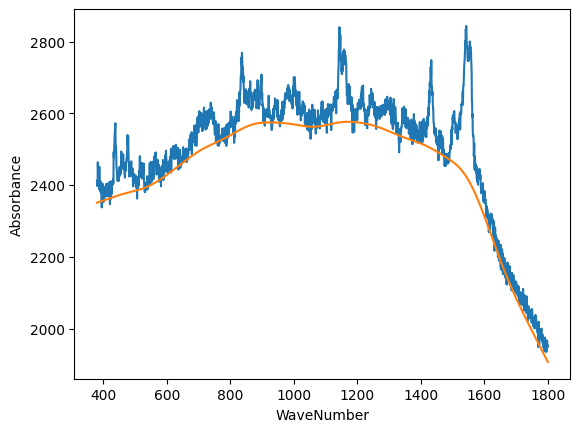

In [29]:
lam = 10 ** 6
p = 0.01

# lam = 10 ** 7
# p = 0.05

# lam = 10 ** 9
# p = 0.1
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p, niter=10))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

/tmp/ipykernel_21741/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

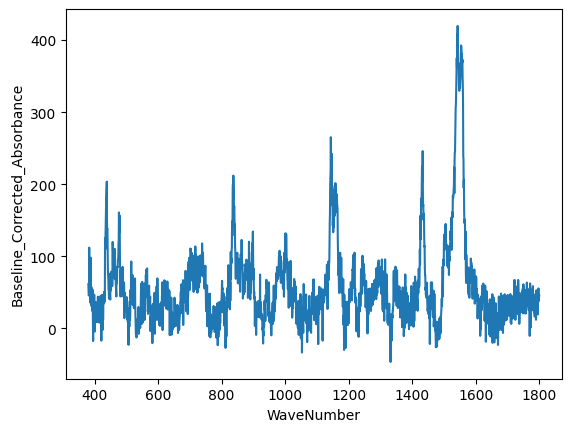

In [30]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Remove the noise from the spectra using Savitzky–Golay-filtering on the raw spectrum.

/tmp/ipykernel_21741/2008908675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

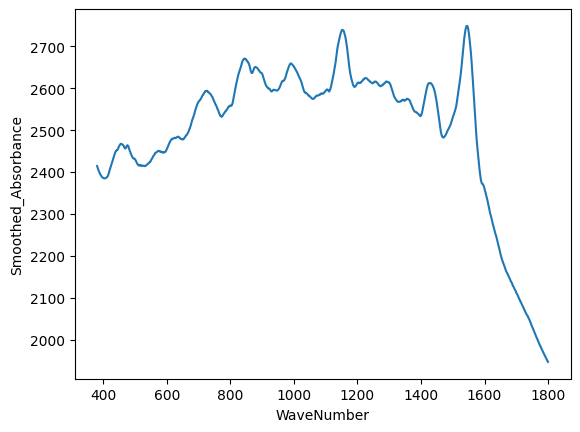

In [31]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

Try it on the Baseline_Corrected_Spectrum

/tmp/ipykernel_21741/1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

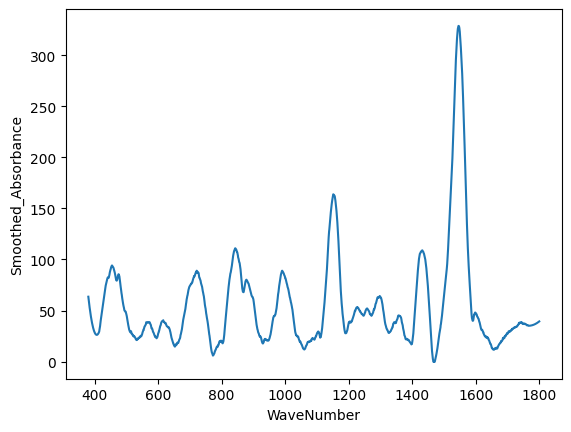

In [32]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

/tmp/ipykernel_20797/1280720429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, 9, 2, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

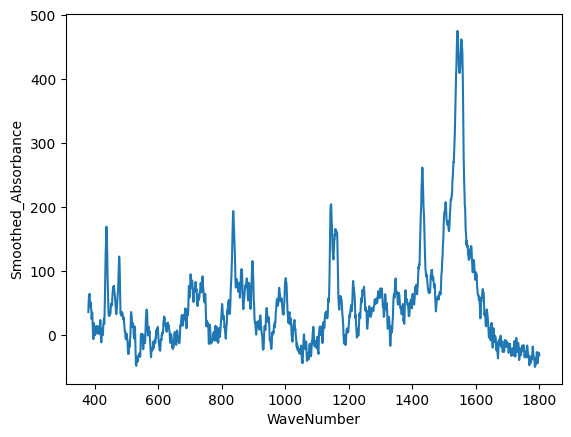

In [67]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, 9, 2, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

>Based on hand tuned parameters lets see how they affect the Machine Learning Classification.

In [68]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df.groupby('SpecID')['Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p, niter=10))

In [69]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance,Baseline_Corrected_Absorbance
264,201210-1-00,264,380.41003,1843.2512,201210-1,Normal,0.995320,1843.2512,0.995320,97.903716
265,201210-1-00,265,381.09338,1839.0771,201210-1,Normal,0.993066,1839.0771,0.993066,93.886492
266,201210-1-00,266,381.77676,1825.5864,201210-1,Normal,0.985781,1825.5864,0.985781,80.552667
267,201210-1-00,267,382.46014,1820.9634,201210-1,Normal,0.983285,1820.9634,0.983285,76.086543
268,201210-1-00,268,383.14349,1823.1549,201210-1,Normal,0.984468,1823.1549,0.984468,78.434918


In [70]:
baseline_corrected_df = prepare_wavelength_df(df, 'Baseline_Corrected_Absorbance')

In [71]:
baseline_corrected_df.head()

,380.41003,381.09338,381.77676,382.46014,383.14349,383.82687,384.51025,385.19363,385.87698,386.56036,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,97.903716,93.886492,80.552667,76.086543,78.434918,81.082893,61.505868,57.196843,59.528518,71.793592,...,-9.464512,-14.913536,-10.996759,0.710818,-14.049305,-12.910328,-28.674050,-27.542672,-32.365294,Normal
201210-1-01,81.383751,60.170315,58.473878,89.395842,83.276805,102.623368,74.781732,62.562595,35.164758,37.177621,...,-39.879207,3.851507,-14.644480,-17.222965,-23.295351,-23.804037,-22.343422,-14.597708,-5.051993,Normal
201210-1-02,126.624977,132.201105,139.020132,141.838260,157.021987,132.691114,117.100241,137.322168,141.266694,133.524620,...,-25.706324,-46.031593,-32.929161,-25.372528,-42.014494,-44.873861,-25.799026,-46.288792,-49.012658,Normal
201210-1-03,310.465716,317.692465,309.022014,275.937064,283.171913,300.067061,247.661110,255.946957,250.984004,232.336450,...,-66.145975,-82.983113,-51.838649,-71.747584,-62.591018,-65.299252,-53.610385,-31.836518,-68.465852,Normal
201210-1-04,117.858214,119.258767,142.555420,131.423773,85.448426,122.483579,109.630531,122.847384,115.387836,81.063388,...,-50.248274,-41.837337,-97.101199,-86.417360,-85.012920,-79.535079,-62.027538,-78.061397,-40.680655,Normal


In [72]:
evaluate_extra_trees(baseline_corrected_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8949 +/- 0.0169


Scale the Baseline Corrected Absorbances to the highest peak.

In [73]:
df['Scaled_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: normalise(x))

In [74]:
scaled_baseline_df = prepare_wavelength_df(df, 'Scaled_Baseline_Corrected')

In [75]:
evaluate_extra_trees(scaled_baseline_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8447 +/- 0.0171


> Lets try 2 different Savitsky Golay Approaches on the Raw and Baseline Corrected Spectra with and without scaling

In [76]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [77]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [78]:
evaluate_extra_trees(smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8407 +/- 0.0200


In [79]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [80]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [81]:
evaluate_extra_trees(scaled_smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8470 +/- 0.0178


In [82]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [83]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [84]:
evaluate_extra_trees(smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8296 +/- 0.0158


In [85]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [86]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [87]:
evaluate_extra_trees(scaled_smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8617 +/- 0.0244


Try this on the baseline corrected spectra.

In [88]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [89]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [90]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9130 +/- 0.0210


In [91]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [92]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [93]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8637 +/- 0.0249


In [94]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [95]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [96]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9238 +/- 0.0121


In [97]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [98]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [99]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8818 +/- 0.0256


This is worse, lets try vector normalisation, where the spectra are scaled by their euclidean norm.

In [101]:
def vector_normalise(absorbances):
    l2_norm = np.sqrt(np.sum(absorbances**2))  # Calculate the euclidean norm
    normalized_absorbances = absorbances / l2_norm
    return normalized_absorbances

df['Vector_Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: vector_normalise(x))

In [102]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: vector_normalise(x))

In [103]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [104]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8864 +/- 0.0210


----

The negative impact of scaling the unsmoothed baseline is strange.

In [105]:
df['No_Below_Baseline'] = np.where(df['Baseline_Corrected_Absorbance'] < 0, 0, df['Baseline_Corrected_Absorbance'])

In [106]:
no_negative = prepare_wavelength_df(df, 'No_Below_Baseline')

In [107]:
evaluate_extra_trees(no_negative)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8910 +/- 0.0159


Then with scaling.

In [108]:
df['Scaled_No_Below_Baseline'] = np.where(df['Scaled_Baseline_Corrected'] < 0, 0, df['Scaled_Baseline_Corrected'])

In [109]:
scaled_no_negative = prepare_wavelength_df(df, 'Scaled_No_Below_Baseline')

In [110]:
scaled_no_negative.head()

,380.41003,381.09338,381.77676,382.46014,383.14349,383.82687,384.51025,385.19363,385.87698,386.56036,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.552822,0.530139,0.454848,0.429630,0.442890,0.457842,0.347299,0.322967,0.336133,0.405389,...,0.0,0.000000,0.0,0.004014,0.0,0.0,0.0,0.0,0.0,Normal
201210-1-01,0.358114,0.264769,0.257304,0.393370,0.366444,0.451576,0.329063,0.275295,0.154736,0.163593,...,0.0,0.016948,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
201210-1-02,0.078562,0.082022,0.086252,0.088001,0.097421,0.082326,0.072653,0.085199,0.087646,0.082843,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
201210-1-03,0.289519,0.296258,0.288172,0.257320,0.264066,0.279821,0.230951,0.238678,0.234050,0.216661,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
201210-1-04,0.385483,0.390064,0.466261,0.429853,0.279479,0.400612,0.358573,0.401801,0.377403,0.265137,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal


In [111]:
evaluate_extra_trees(scaled_no_negative)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8430 +/- 0.0211


Try Min-Max Scaling Instead

In [112]:
def min_max_scale(absorbances):
    min_value = np.min(absorbances)
    max_value = np.max(absorbances)
    return (absorbances - min_value) / (max_value - min_value)

df['MinMax_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: min_max_scale(x))

In [113]:
min_max_raw_df = prepare_wavelength_df(df, 'MinMax_Absorbance')

In [114]:
evaluate_extra_trees(min_max_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8519 +/- 0.0183


In [115]:
df['MinMax_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: min_max_scale(x))

In [116]:
min_max_baseline_df = prepare_wavelength_df(df, 'MinMax_Baseline')

In [117]:
min_max_baseline_df.head()

,380.41003,381.09338,381.77676,382.46014,383.14349,383.82687,384.51025,385.19363,385.87698,386.56036,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.677009,0.660625,0.606243,0.588028,0.597606,0.608406,0.528561,0.510987,0.520497,0.570520,...,0.239111,0.216887,0.232862,0.280611,0.220412,0.225057,0.160765,0.165380,0.145711,Normal
201210-1-01,0.506361,0.434574,0.428833,0.533474,0.512767,0.578237,0.484019,0.442669,0.349954,0.356765,...,0.096002,0.243988,0.181397,0.172671,0.152122,0.150401,0.155343,0.181555,0.213858,Normal
201210-1-02,0.142548,0.145768,0.149705,0.151332,0.160098,0.146050,0.137049,0.148724,0.151002,0.146532,...,0.054600,0.042865,0.050430,0.054793,0.045185,0.043534,0.054547,0.042717,0.041144,Normal
201210-1-03,0.397351,0.403067,0.396209,0.370039,0.375761,0.389125,0.347672,0.354227,0.350301,0.335551,...,0.099452,0.086134,0.110769,0.095021,0.102264,0.100122,0.109368,0.126591,0.097617,Normal
201210-1-04,0.543532,0.546935,0.603535,0.576490,0.464792,0.554770,0.523543,0.555654,0.537530,0.454138,...,0.135113,0.155547,0.021282,0.047239,0.050651,0.063960,0.106495,0.067540,0.158358,Normal


In [118]:
evaluate_extra_trees(min_max_baseline_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8276 +/- 0.0305


In [119]:
vector_scale_raw = prepare_wavelength_df(df, "Vector_Scaled_Absorbance")

In [120]:
evaluate_extra_trees(vector_scale_raw)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9005 +/- 0.0172


Try on the baseline corrected spectra.

In [121]:
df['Vector_Scaled_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: vector_normalise(x))

In [122]:
vector_scale_baseline = prepare_wavelength_df(df, 'Vector_Scaled_Baseline')

In [123]:
evaluate_extra_trees(vector_scale_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8483 +/- 0.0230
